# Purpose of Notebook

The purpose of this notebook is to globally fit the two recrystillization models independently to experimental data using nonlinear least squares. I will use prior estimates of the model parameters from [arrhenius_process_estimation.ipynb](arrhenius_process_estimation.ipynb) to assist in the initialization of the parameters. 

These estimates are in turn meant only to assist in the initialization in the [recrystillization_inference.ipynb](../model_inference/recrystillization_inference.ipynb) modules, so I won't go much into the relatile quality of the fits/analysis of the results. 

In [1]:
import numpy as np
from scipy.optimize import differential_evolution, curve_fit
from typing import Callable
import math
import warnings
from matplotlib import pyplot as plt
from matplotlib import rc
from pathlib import WindowsPath, PosixPath
import sys

PathPath = WindowsPath if 'win' in sys.platform.lower() else PosixPath
PARENT_DIR = PathPath('../')
DATA_DIR = PARENT_DIR.joinpath('rf_data')
MODEL_PATH = PARENT_DIR.joinpath('.model')

sys.path.append(str(PARENT_DIR))

from common_util import LogLinearArrheniusModelFunc,jmak_function,generalized_logistic,get_data_label
from scipy.stats.qmc import LatinHypercube

rc('font',**{'family':'serif','serif':['Times New Roman'],'weight': 'bold'})
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = "".join([r"\usepackage{newtxtext,newtxmath}",r"\boldmath"])
warnings.filterwarnings('ignore',category = RuntimeWarning)
warnings.filterwarnings('ignore',category = SyntaxWarning)

def global_optimize_ls(f: Callable,
                       xdata: np.ndarray,
                       ydata: np.ndarray,
                       bounds: np.ndarray,
                       sigma: np.ndarray = None,
                       p0: np.ndarray = None,
                       *args,**kwargs):
    
    """
    handy to check if the local optimization is working okay.
    """
    w = np.ones_like(ydata) if not isinstance(sigma,np.ndarray) and sigma is None else 1/sigma**2
    w/=np.linalg.norm(w)

    def resid(theta: np.ndarray):
        return np.sum((w*(ydata - f(xdata,*theta))**2))
    
    return differential_evolution(resid,bounds,*args,polish = True,**kwargs)

def local_optimize_ls(fun: Callable,
                      xdata: np.ndarray,
                      ydata: np.ndarray,
                      bounds: np.ndarray,
                      *args,
                      p0: np.ndarray = None,
                      **kwargs):
    """ 
    small wrapper to interface with fit method in the model function
    """
    xopt,pcov, info_dict,msg, ier = \
          curve_fit(fun,xdata,ydata,*args,p0 = p0,bounds = bounds.T,**kwargs,full_output = True)
    
    return xopt,True,msg

def model_std_dev(fun: Callable,
                  xdata: np.ndarray,
                  ydata: np.ndarray,
                  xopt: np.ndarray, 
                  sigma: np.ndarray = None):
    
    yhat = fun(xdata,*xopt)
    if not isinstance(sigma,np.ndarray) and sigma is None:
        sigma = np.ones_like(ydata)
    
    resid = ydata - yhat
    return np.sum(resid**2/sigma**2)**0.5

def restarted_local_optimize_ls(fun: Callable,
                                xdata: np.ndarray,
                                ydata: np.ndarray,
                                bounds: np.ndarray,
                                *args,
                                opt_metric: Callable = model_std_dev,
                                n_restarts: int = 100,
                                p0: np.ndarray = None,
                                sigma = None,
                                **kwargs):
    
    """
    can't converge to a solution consistnely without a good initial guess.
    """
    params = LatinHypercube(bounds.shape[0]).random(n_restarts - 1)
    params = params*(bounds[:,1] - bounds[:,0]) + bounds[:,0]
    params = np.vstack([params,bounds.mean(axis = 1)])
    metric = np.ones(n_restarts)*float('inf')
    for i in range(params.shape[0]):
        try:
            xopt,_,_ = \
                local_optimize_ls(fun,xdata,ydata,*args,p0 = params[i,:],bounds = bounds,sigma = sigma,
                                **kwargs)
            
            params[i] = xopt
            metric[i] = opt_metric(fun,xdata,ydata,xopt,sigma = sigma)
        except RuntimeError as rte:
            warnings.warn(f'Optimization failed: {str(rte)}')
            pass

    xopt = params[np.argmin(metric)]    
    return xopt,True,True


### Visually Examining Regression Fits

First we'll fit both the JMAK and Generalized Logistic Models to two data sets, the "Highly Rolled" and "Moderately Rolled" data from Alfonso _et al._'s study. We'll use both the linear (squared error) and huber loss functions (for robust estimation) during the optimizations. Because experimental variance (errors) are reported, we should use weighted least squares to weight the samples according to our certainty in their values.

The results of the fits to each data set are written to a file to be loaded and used during inference, so the file names need to be changed and the block re-run for each data file.

C:\Users\mlanahan3\AppData\Local\Temp\ipykernel_284932\1626225759.py:103: UserWarning: Optimization failed: Optimal parameters not found: The maximum number of function evaluations is exceeded.
  warnings.warn(f'Optimization failed: {str(rte)}')
C:\Users\mlanahan3\AppData\Local\Temp\ipykernel_284932\1626225759.py:103: UserWarning: Optimization failed: Optimal parameters not found: The maximum number of function evaluations is exceeded.
  warnings.warn(f'Optimization failed: {str(rte)}')
C:\Users\mlanahan3\AppData\Local\Temp\ipykernel_284932\1626225759.py:103: UserWarning: Optimization failed: Optimal parameters not found: The maximum number of function evaluations is exceeded.
  warnings.warn(f'Optimization failed: {str(rte)}')


result for file: richou_data/batch_a_data.csv
                  model           method      n      a1         B1      a2  \
0                  JMAK         weighted  1.475  32.218 -69866.485 -13.278   
0                  JMAK  robust weighted  1.667  29.823 -65682.645 -14.049   
0  Generalized Logistic         weighted  0.266  32.361 -68506.056 -21.744   
0  Generalized Logistic  robust weighted  0.280  31.675 -67185.021 -22.352   

          B2  std. dev.  max abs. error  log-likelihood  
0  33379.577      1.120           3.594        3855.110  
0  34351.589      1.131           3.779        3847.378  
0  49744.044      1.129           3.772        3848.858  
0  51021.388      1.135           3.838        3844.209  
----------------------------------------



C:\Users\mlanahan3\AppData\Local\Temp\ipykernel_284932\1626225759.py:103: UserWarning: Optimization failed: Optimal parameters not found: The maximum number of function evaluations is exceeded.
  warnings.warn(f'Optimization failed: {str(rte)}')
C:\Users\mlanahan3\AppData\Local\Temp\ipykernel_284932\1626225759.py:103: UserWarning: Optimization failed: Optimal parameters not found: The maximum number of function evaluations is exceeded.
  warnings.warn(f'Optimization failed: {str(rte)}')


result for file: richou_data/batch_b_data.csv
                  model           method      n      a1         B1      a2  \
0                  JMAK         weighted  1.668  18.525 -46922.632 -31.710   
0                  JMAK  robust weighted  1.987  19.242 -48331.341 -34.248   
0  Generalized Logistic         weighted  0.454  18.349 -44676.702 -21.784   
0  Generalized Logistic  robust weighted  0.454  19.695 -47082.912 -21.274   

          B2  std. dev.  max abs. error  log-likelihood  
0  67353.013      0.864           2.050        2421.838  
0  70857.825      0.872           2.159        2416.384  
0  52000.380      0.841           1.897        2438.071  
0  51114.217      0.850           2.142        2431.994  
----------------------------------------



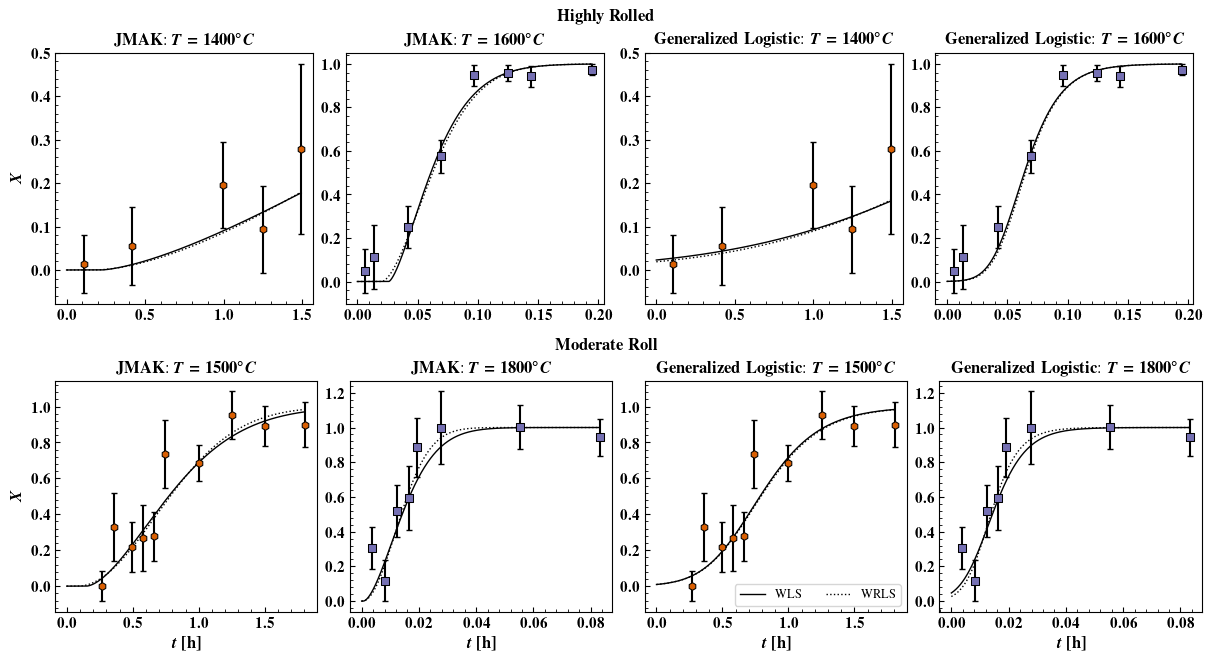

In [8]:
import pandas as pd
import pickle
from common_util import setup_axis_default,jmak_fit_model_setup,gl_fit_model_setup
np.random.seed(55)

#setup fitting for models
model_fit = {'JMAK':(jmak_fit_model_setup,jmak_function),
             'Generalized Logistic':(gl_fit_model_setup,generalized_logistic)}

methods = {'weighted':'linear',
           'robust weighted':'huber'}

models = {}
styles = ['-',':']
labels = ['WLS','WRLS']

#set-up figure and axes
fig = plt.figure(constrained_layout=True,figsize= (12,6.5))
subfigs = fig.subfigures(nrows=2, ncols=1)

axes = []
for row, subfig,row_title in zip(range(2),subfigs,['Highly Rolled','Moderate Roll']):
        subfig.suptitle(r'\textbf{' + row_title +  '}',fontsize = 12)
        axs = subfig.subplots(nrows=1, ncols=4)
        axes.append(axs)

axes = np.array(axes)

colors = plt.get_cmap('Dark2')([0.2,0.3])

data_files = {'richou_data/batch_a_data.csv': [],
              'richou_data/batch_b_data.csv': []}

columns = ['model','method','n','a1','B1','a2','B2','std. dev.','max abs. error','log-likelihood'] 

for j,file,temperatures in zip(range(2),data_files,[[1400,1600],[1500,1800]]):
        results_frames = []
        data_file = DATA_DIR.joinpath(f'{file}')
        data = pd.read_csv(data_file,index_col = 0)
        start_index = 0

        for model_to_fit in model_fit:
                setup,fit_func = model_fit[model_to_fit]
                for method,ls,label in zip(methods,styles,labels): 
                        results = [] 
                        
                        #set-up model fitting and fit model
                        t,T,X,df,bounds,p0 = setup(str(data_file),mult = 1,
                                                   exclude_index = data_files[file])        
                        
                        sigma = df['std'].to_numpy()
                        model = LogLinearArrheniusModelFunc().fit(fit_func,t,T,X,restarted_local_optimize_ls,bounds.copy(),
                                                                  sigma = sigma,loss = methods[method],p0 = p0,max_nfev = 5000)
                        
                        #write to file for later use
                        with open(MODEL_PATH.joinpath(f'{model_to_fit}_{get_data_label(data_file)}_{method}.pkl'),'wb') as f:
                                pickle.dump(model,f)
                        
                        #get summary statistics
                        resid = X - model.predict(np.array([t,T]).T)
                        n = resid.shape[0]
                        std_dev = np.mean(resid**2/sigma**2)**0.5
                        max_err = np.max(np.abs(resid/sigma))
                        log_like = -n*math.log(2*math.pi) - n/2*np.log(np.prod(std_dev*sigma**2)) - 0.5*np.sum(resid**2/(std_dev*sigma)**2)

                        results.append([model_to_fit,method,
                                        *np.round(model.parameters(),3),
                                        round(std_dev,3),
                                        round(max_err,3),
                                        round(log_like,3)])
                        
                        #vizualize the model performance
                        for i,T_plot in enumerate(temperatures):
                                data_df = data.loc[data['temperature'] == T_plot]
                                tplot = np.linspace(0,data_df['time'].max(),1000)
                                Xnew = np.array([tplot,(T_plot + 273.15)*np.ones_like(tplot)]).T
                                axes[j,i + start_index].plot(tplot/3600,model.predict(Xnew),
                                        color = 'k',lw = 1.,label = label,ls = ls)
                        
                        results_frames.append(pd.DataFrame(results,columns = columns))  
                
                #scatter plot selected values of the fitted data
                for i,marker,color,T_plot in zip(range(2),['h','s'],colors,temperatures):
                        title = r'\textbf{' + f'{model_to_fit}' + '}' + f': $T = {T_plot} ^\circ C$'
                        data_df = data.loc[data['temperature'] == T_plot]
                        axes[j,i + start_index].set_title(title,fontsize = 12)
                        try:
                                axes[j,i + start_index].errorbar(data_df['time']/3600,data_df['X'].to_numpy(),yerr = data_df['std'],fmt = 'none',ecolor = 'k',capsize = 2)
                        except KeyError: 
                                pass
                
                        axes[j,i + start_index].scatter(data_df['time']/3600,data_df['X'],facecolor  = color,edgecolor = 'k',
                                lw = 0.75,s = 30,marker = marker,zorder = 1000) 
                
                start_index +=2
        

        print(f'result for file: {file}')
        print(pd.concat(results_frames))

        print('----------------------------------------\n')


#final formatting for plots
for ax in np.ravel(axes)[4:]:
        ax.set_xlabel(r'$t$ \textbf{[h]}',fontsize = 12)

for ax in np.ravel(axes):
        setup_axis_default(ax)

for i in range(2):
        axes[i,0].set_ylabel(r'$X$',fontsize = 12)

axes[1,2].legend(fontsize = 9,ncols = 2)
#fig.savefig('images/example_model_fit_alfonso.svg',bbox_inches = 'tight')


## Shah Data

Because the experiments are different than the other data sets.

### JMAK

In [11]:
from common_util import setup_axis_default,jmak_fit_model_setup,gl_fit_model_setup,read_prepare_data
import pickle

data_files = ['richou_data/batch_a_data.csv','richou_data/batch_b_data.csv','alfonso_data/moderate_roll.csv','alfonso_data/highly_rolled.csv',
              'yu_data/data.csv']

multipliers = [3600,3600,1,1,1]
bounds = []
for file,mult in zip(data_files,multipliers):
    bounds.append(jmak_fit_model_setup(str(DATA_DIR.joinpath(file)),mult = mult)[-2][...,np.newaxis])   

bounds = np.concatenate(bounds,axis = -1)
lower = np.min(bounds,axis = (-2,-1))
upper = np.max(bounds,axis = (-1,-2))
bounds = np.stack([lower,upper],axis = -1)
p0 = np.mean(bounds,axis = -1)
data_file = DATA_DIR.joinpath('shah_data/data.csv')
t,T,X,df = read_prepare_data(data_file)
sigma = df['std'].to_numpy()
model = LogLinearArrheniusModelFunc().fit(jmak_function,t,T,X,restarted_local_optimize_ls,bounds.copy(),
                                            sigma = sigma,loss = 'linear',p0 = p0,max_nfev = 5000)

np.save(MODEL_PATH.joinpath(f'JMAK_{get_data_label(data_file)}_bounds.npy'),bounds)
with open(MODEL_PATH.joinpath(f'JMAK_{get_data_label(data_file)}_weighted.pkl'),'wb') as f:
        pickle.dump(model,f)

No standard deviation column found, using 0.001 for all values


C:\Users\mlanahan3\AppData\Local\Temp\ipykernel_126268\1626225759.py:103: UserWarning: Optimization failed: Optimal parameters not found: The maximum number of function evaluations is exceeded.
  warnings.warn(f'Optimization failed: {str(rte)}')


### Generalized Logistic

In [12]:

data_files = ['richou_data/batch_a_data.csv','richou_data/batch_b_data.csv','alfonso_data/moderate_roll.csv','alfonso_data/highly_rolled.csv',
              'yu_data/data.csv']

multipliers = [3600,3600,1,1,1]
bounds = []
for file,mult in zip(data_files,multipliers):
    bounds.append(gl_fit_model_setup(str(DATA_DIR.joinpath(file)),mult = mult)[-2][...,np.newaxis])   

bounds = np.concatenate(bounds,axis = -1)
lower = np.min(bounds,axis = (-2,-1))
upper = np.max(bounds,axis = (-1,-2))
bounds = np.stack([lower,upper],axis = -1)
p0 = np.mean(bounds,axis = -1)
data_file = DATA_DIR.joinpath('shah_data/data.csv')
t,T,X,df = read_prepare_data(data_file)
sigma = df['std'].to_numpy()
model = LogLinearArrheniusModelFunc().fit(generalized_logistic,t,T,X,restarted_local_optimize_ls,bounds.copy(),
                                            sigma = sigma,loss = 'linear',p0 = p0,max_nfev = 5000)

np.save(MODEL_PATH.joinpath(f'Generalized Logistic_{get_data_label(data_file)}_bounds.npy'),bounds)
print(model.parameters())
with open(MODEL_PATH.joinpath(f'Generalized Logistic_{get_data_label(data_file)}_weighted.pkl'),'wb') as f:
        pickle.dump(model,f)

No standard deviation column found, using 0.001 for all values


C:\Users\mlanahan3\AppData\Local\Temp\ipykernel_126268\1626225759.py:103: UserWarning: Optimization failed: Optimal parameters not found: The maximum number of function evaluations is exceeded.
  warnings.warn(f'Optimization failed: {str(rte)}')


[ 5.55762484e-01  2.50472029e+01 -5.30078475e+04 -2.81515402e+01
  5.65022589e+04]
